* one convolution notebook

In [3]:
# tensorflow on 8889

In [1]:
import os
os.chdir("/notebooks/src")

In [2]:
pwd

u'/notebooks/src'

In [68]:
! ls /home

In [69]:
!pip install keras cython h5py

In [3]:
import keras
from keras.layers import Input, Convolution2D, Dense, Activation, Flatten, merge, Conv2D
from keras.layers import MaxPooling2D, Dropout, LocallyConnected2D, MaxPool2D, MaxPool1D
from keras.models import Model, load_model,  Sequential
from keras.optimizers import SGD
from keras.models import Sequential
from keras.activations import relu, softmax
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from lib.data_split import load_train_data, load_test_data

Using TensorFlow backend.


### preprocessing the data(functions)

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
'''
This module takes a file path and loades pre_extracted features 
from leaf kaggle competiton. The input is the file path for
train or test files. 
'''



def load_train(filepath):

    #loading
    train_df = pd.read_csv(filepath)
    id = train_df.pop('id')
    target = train_df.pop('species')
    
    #scaling
    target = LabelEncoder().fit(target).transform(target)
    features = StandardScaler().fit(train_df).transform(train_df)
    
    return id,features,target
    

def load_test(filepath):
    
    #loading
    test_df = pd.read_csv(filepath)
    id = test_df.pop('id')
    
    #scaling
    features = StandardScaler().fit(test_df).transform(test_df)
    
    return id, features
    

* loading images

In [5]:
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import img_to_array, load_img

'''
This module loads all the training/test images, resizes them and 
makes them ready for kaggle.
'''


def rebuild_image(img, dim=64):
    
    # find largest axis
    maxsize = max((0,1), key=lambda i: img.size[i])
    
    #scale both axis
    scale = dim/float(img.size[maxsize])
    
    return img.resize((int(img.size[0] * scale), int(img.size[1]*scale)))
    

    
def load_image(ids,dim=64):

    filepath = './data/images/'
    
    IM = np.empty((len(ids),dim,dim,1))
    
    for i, ids in enumerate(ids):
    
        images = rebuild_image(load_img(filepath + str(ids) + '.jpg',
grayscale=True),dim = dim)
        
        images = img_to_array(images)
        x = images.shape[0]
        y = images.shape[1]
        
        #centering
        l_bound_0 = int((dim - x) / 2)
        u_bound_0 = l_bound_0 + x
        l_bound_1 = int((dim - y) / 2)
        u_bound_1 = l_bound_1 + y
        
        IM[i,l_bound_0:u_bound_0,l_bound_1:u_bound_1,0:1] = images
        
        #scale it to grey
    return np.around(IM/ 255.0) 

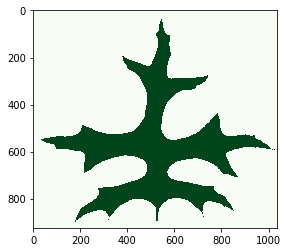

In [6]:
# reading an image file using matplotlib into a numpy array
# good ones: 11, 19, 23, 27, 48, 53, 78, 218
img = mpimg.imread('./data/images/53.jpg')
plt.imshow(img, cmap='Greens') 
plt.show()

### splitting the data with StratifiedShuffleSplit

In [7]:

from sklearn.model_selection import StratifiedShuffleSplit

random_state = 8
split = 0.8



def load_train_data(filepath, split = split, random_state = random_state):

    id, features_train, target_train = load_train(filepath)
    image_train = load_image(id)
    
    sss = StratifiedShuffleSplit(n_splits = 1, train_size=split ,random_state=random_state)
    train_i,val_i = next(sss.split(features_train,target_train))
      
    features_val,val_img,val_target = features_train[val_i],image_train[val_i], target_train[val_i]
      
    features_train,train_img,train_target = features_train[train_i],image_train[train_i],target_train[train_i]
    
    
    return (features_train,train_img,train_target),(features_val,val_img,val_target)
    

def load_test_data(filepath):

    id, test_features = load_test(filepath)
    test_images = load_image(id)
    
    return (id,test_features,test_images)
    
    

In [8]:
#X_train, y_train
train,validation = load_train_data("./data/train.csv",split = split, random_state = random_state)

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_split.py:1630: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [9]:
train[0].shape

(792, 192)

In [10]:
test = load_test_data("./data/test.csv")

In [11]:
type(test)

tuple

In [12]:
train_labels = train[2][:]
valid_labels = validation[2][:]

In [13]:
train_labels.shape

(792,)

In [80]:
train_labels

array([78, 69, 33, 89, 92, 73, 75, 23, 17, 88, 69, 35, 97, 52, 87, 23, 18,
       24, 70, 95, 80, 43, 22,  1, 84, 68, 34, 76, 36, 61, 32, 93, 95,  1,
       55, 59, 33, 97, 22,  6, 28, 38, 50, 96, 85, 85, 82, 37, 47, 25, 41,
       54, 33, 36, 70, 55, 42, 84, 63,  6, 51, 37,  6, 62, 43,  2, 30, 28,
        2, 19, 74, 77, 14, 26, 21, 93,  7, 83, 56, 77, 62, 72,  3, 24, 89,
       20, 71, 58,  4, 29, 68,  9, 33, 39, 30, 13, 92, 10, 81, 37, 61, 20,
       89, 90,  3, 81, 79, 29, 80, 12, 34, 43, 37,  9, 16, 50, 74,  8, 60,
       96, 13,  0, 69, 78, 10, 65, 47, 58, 92, 90,  5, 71, 30, 33, 56, 73,
       21, 86, 53,  5, 15, 64, 16, 82, 62, 64, 47, 53, 30, 42, 45, 50, 63,
       65, 14, 28, 44, 28, 75, 72, 82, 94, 39, 10, 78, 67, 20, 71, 64, 75,
       44,  4, 92, 43, 47, 88, 46, 16, 25, 23,  0,  7,  6, 85, 35, 70,  7,
       53,  9, 43, 59, 67, 59, 79, 68, 17, 11, 98, 77, 20, 31,  4, 21, 41,
        8, 57, 24, 89, 87, 68, 74, 46,  2, 18, 92,  7, 51, 70, 68, 92, 90,
       63, 12, 32, 98, 45

In [81]:
valid_labels.shape

(99,)

In [82]:
valid_labels

array([96,  4, 80,  8, 26,  7, 98, 38, 53, 72, 68, 58, 34, 60, 89,  9, 86,
       54, 40,  6, 21, 49, 29, 75, 91, 27, 33, 11, 95, 57, 32, 35, 61, 19,
       12, 44, 31, 41, 24, 94, 30, 18, 17,  1, 45, 20, 48, 10, 84, 67, 37,
       81, 93, 59, 66, 23, 22, 64, 83, 46, 69, 25, 79, 50, 47, 90, 51,  3,
       15,  2, 39, 73,  5, 63, 97, 82, 92, 85, 74, 36, 71, 13, 14, 70, 88,
       55, 28, 16, 56,  0, 43, 65, 76, 42, 52, 78, 77, 62, 87])

### reformat function

In [14]:
def reformat(labels):
    labels = (np.arange(99) == labels[:,None]).astype(np.float32)
    return labels
train_labels = reformat(train_labels)
valid_labels = reformat(valid_labels)

In [15]:
train_labels.shape

(792, 99)

In [85]:
train_labels

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [16]:
valid_labels.shape

(99, 99)

In [87]:
valid_labels

array([[ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [17]:
input_layer = Input(shape=(64,64,1))

In [18]:
input_layer

<tf.Tensor 'input_1:0' shape=(?, 64, 64, 1) dtype=float32>

In [19]:
input_layer.shape

TensorShape([Dimension(None), Dimension(64), Dimension(64), Dimension(1)])

### Frankenstein Neural Network (FNN)
* Neural Network the functional way ( concating images and features)

In [125]:
# first network only for the images

Input_layer = Input(shape=(64,64,1))

first = Conv2D(8, kernel_size=(3,3), activation= "relu", padding= "same")(Input_layer)

first = Conv2D(16, kernel_size=(3,3), activation = "relu")(first)

first = Dropout(.5)(first)

first = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(first)

first = Flatten()(first)

In [126]:
#second network only for the pre_extracted features

Input_layer_features = Input(shape=(192,1),name='second')

second = Dense(100, activation = "relu")(Input_layer_features)

second = MaxPool1D()(second)

second = Flatten()(second)


In [127]:

from keras.layers import concatenate#,Add

In [128]:
#concating the first network(the images only) and the second network(the pre_extracted features only)
combined = concatenate([first,second])
type(combined)

tensorflow.python.framework.ops.Tensor

In [129]:
combined = Dense(100, activation= "relu")(combined)
combined = Dropout(.5)(combined)
#output layer
output_layer = Dense(99, activation="softmax")(combined)

In [130]:
output_layer

<tf.Tensor 'dense_24/Softmax:0' shape=(?, 99) dtype=float32>

In [131]:
validation[1][:].shape

(99, 64, 64, 1)

In [132]:
validation[0][:].shape

(99, 192)

In [133]:

model = Model(inputs=[Input_layer, Input_layer_features],outputs=output_layer)

In [134]:
#every time you compile your model It will start over the scoring
model.compile(optimizer='adam',loss='categorical_crossentropy',
              metrics=['accuracy'])

In [123]:
# train[1][:].shape
# train[0][:].reshape((792,192,1))

In [137]:
#reshaping from 2D to 3D
train_features = train[0][:].reshape((792,192,1))
validation_features = validation[0][:].reshape((99,192,1))

In [139]:
model.fit([train[1][:],train_features], train_labels, validation_data = ([validation[1][:],validation_features],valid_labels),epochs= 20)


Train on 792 samples, validate on 99 samples
Epoch 1/20
792/792 [==============================] - 4s - loss: 4.5734 - acc: 0.0253 - val_loss: 4.1950 - val_acc: 0.1010
Epoch 2/20
792/792 [==============================] - 3s - loss: 3.9926 - acc: 0.0833 - val_loss: 3.5116 - val_acc: 0.2828
Epoch 3/20
792/792 [==============================] - 3s - loss: 3.2344 - acc: 0.2210 - val_loss: 2.6663 - val_acc: 0.4848
Epoch 4/20
792/792 [==============================] - 3s - loss: 2.5039 - acc: 0.3396 - val_loss: 1.8483 - val_acc: 0.7879
Epoch 5/20
792/792 [==============================] - 3s - loss: 1.8919 - acc: 0.4722 - val_loss: 1.1577 - val_acc: 0.9293
Epoch 6/20
792/792 [==============================] - 4s - loss: 1.4627 - acc: 0.5783 - val_loss: 0.6830 - val_acc: 0.9394
Epoch 7/20
792/792 [==============================] - 4s - loss: 1.1697 - acc: 0.6616 - val_loss: 0.5069 - val_acc: 0.9697
Epoch 8/20
792/792 [==============================] - 4s - loss: 0.9239 - acc: 0.7273 - val_lo

 ### Sequential Convolutional Neural Network(CNN)-images only

In [137]:
#start with the images only.

cnn = Sequential([
    Conv2D(8, kernel_size=(3,3),
          activation= "relu",
          input_shape = (64,64,1)),
    Conv2D(16, kernel_size=(3,3), 
           activation = "relu"),
    Dropout(.25),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    Flatten(),
    Dense(100, activation = "relu"),
    Dropout(.25),
    #output _ layer
    Dense(256),
    Dense(99, activation= "softmax")
])

In [108]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 62, 62, 8)         80        
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 60, 60, 16)        1168      
_________________________________________________________________
dropout_18 (Dropout)         (None, 60, 60, 16)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 30, 16)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 14400)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 100)               1440100   
_________________________________________________________________
dropout_19 (Dropout)         (None, 100)               0         
__________

In [109]:
cnn.compile(loss= keras.losses.categorical_crossentropy,
           optimizer= keras.optimizers.adam(),
           metrics=["accuracy"])

In [110]:
# for images only ==> train[1] and validation[1]
history = cnn.fit(train[1],train_labels, validation_data=(validation[1], valid_labels),nb_epoch=20)

Train on 792 samples, validate on 99 samples
Epoch 1/20
792/792 [==============================] - 3s - loss: 4.5576 - acc: 0.0202 - val_loss: 4.2439 - val_acc: 0.0808
Epoch 2/20
792/792 [==============================] - 3s - loss: 3.7604 - acc: 0.0846 - val_loss: 3.1458 - val_acc: 0.1818
Epoch 3/20
792/792 [==============================] - 3s - loss: 2.8101 - acc: 0.2449 - val_loss: 2.4668 - val_acc: 0.3535
Epoch 4/20
792/792 [==============================] - 3s - loss: 2.2514 - acc: 0.3245 - val_loss: 2.1048 - val_acc: 0.4242
Epoch 5/20
792/792 [==============================] - 3s - loss: 1.8565 - acc: 0.4571 - val_loss: 1.8336 - val_acc: 0.5152
Epoch 6/20
792/792 [==============================] - 3s - loss: 1.7217 - acc: 0.4722 - val_loss: 1.7084 - val_acc: 0.5354
Epoch 7/20
792/792 [==============================] - 3s - loss: 1.4511 - acc: 0.5682 - val_loss: 1.5166 - val_acc: 0.5354
Epoch 8/20
792/792 [==============================] - 3s - loss: 1.2963 - acc: 0.5960 - val_lo

In [124]:
train[1][:].shape

(792, 64, 64, 1)

In [125]:
train[0][:].shape

(792, 192)

In [16]:
#you need an optimizer anyway.
#sgd = SGD(lr=0.008, momentum=0.9,decay=0.0,nesterov=False)

In [17]:
# for image + numerical data
model = Model(input=[input_layer,num],output=output_layer)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`
  


In [18]:
#model.compile(optimizer='Adam',loss='categorical_crossentropy',
#              metrics=['accuracy'])

In [59]:
#!pip install seaborn